In [3]:
!pip install psycopg2-binary sqlalchemy sentence-transformers fastapi uvicorn streamlit openai


In [1]:
import os
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from dotenv import load_dotenv

os.chdir("/Users/yshmbid/Documents/home/github/SQL")  # set path
load_dotenv() 

True

In [2]:
# 1. 데이터 불러오기
df = pd.read_csv("17. CSV → Pandas → PostgreSQL 적재 실습_user_behavior.csv")
df

,user_id,age,income,gender,spending_score,visit_count
0,U0001,56,6132,M,37,3
1,U0002,46,5851,F,75,1
2,U0003,32,5440,F,70,4
3,U0004,25,5766,M,18,2
4,U0005,38,7644,M,85,3
...,...,...,...,...,...,...
495,U0496,56,7042,F,50,4
496,U0497,49,8717,M,71,1
497,U0498,41,7560,M,3,2
498,U0499,40,6289,F,93,2


In [3]:
# 2. PostgreSQL 연결
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    database="postgres",
    user="postgres",
    password=os.getenv("PG_PASSWORD"),  # 환경변수에서 불러오기
)
cur = conn.cursor()

# 테이블 생성
cur.execute("""
CREATE TABLE IF NOT EXISTS user_behavior (
    user_id VARCHAR(10) PRIMARY KEY,
    age INTEGER,
    income INTEGER,
    gender VARCHAR(1),
    spending_score INTEGER,
    visit_count INTEGER
);
""")
conn.commit()

In [4]:
# 3. 데이터 적재 (CSV → DB)
for _, row in df.iterrows():
    cur.execute("""
        INSERT INTO user_behavior (user_id, age, income, gender, spending_score, visit_count)
        VALUES (%s, %s, %s, %s, %s, %s)
        ON CONFLICT (user_id) DO NOTHING;
    """, (row['user_id'], row['age'], row['income'], row['gender'], row['spending_score'], row['visit_count']))
conn.commit()

In [5]:
# 4. pgvector 확장 + 임베딩 컬럼 추가
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
cur.execute("""
CREATE TABLE IF NOT EXISTS user_embeddings (
    user_id VARCHAR(10) PRIMARY KEY,
    embedding vector(384)
);
""")
conn.commit()

In [6]:
# 5. 임베딩 생성 및 업데이트
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

#for uid in df['user_id']:
#    vec = model.encode(uid).tolist()
#    cur.execute("""
#        INSERT INTO user_embeddings (user_id, embedding)
#        VALUES (%s, %s)
#        ON CONFLICT (user_id) DO UPDATE SET embedding = EXCLUDED.embedding;
#    """, (uid, vec))

# description 컬럼 생성
df["description"] = df.apply(
    lambda row: f"{row['age']}세 {row['gender']} 사용자, 소득 {row['income']}, "
                f"소비 성향 {row['spending_score']}, 방문 횟수 {row['visit_count']}회",
    axis=1
)

# DB에 벡터 저장
for uid, desc in zip(df['user_id'], df['description']):
    vec = model.encode(desc).tolist()
    cur.execute("""
        INSERT INTO user_embeddings (user_id, embedding)
        VALUES (%s, %s)
        ON CONFLICT (user_id) DO UPDATE SET embedding = EXCLUDED.embedding;
    """, (uid, vec))

conn.commit()

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# 8. RAG / LLM 응용
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def rag_query(user_id: str):
    conn = psycopg2.connect(
        host="localhost",
        port=5432,
        database="postgres",
        user="postgres",
        password=os.getenv("PG_PASSWORD"),
    )
    cur = conn.cursor()
    cur.execute("""
        SELECT ub.user_id, ub.age, ub.income, ub.spending_score
        FROM user_behavior ub
        JOIN user_embeddings ue ON ub.user_id = ue.user_id
        ORDER BY ue.embedding <=> (SELECT embedding FROM user_embeddings WHERE user_id = %s)
        LIMIT 3;
    """, (user_id,))
    rows = cur.fetchall()
    conn.close()

    context = "\n".join([str(r) for r in rows])
    prompt = f"""
    다음은 유사한 사용자 데이터입니다:
    {context}

    위 정보를 참고하여 {user_id} 사용자의 맞춤형 추천 설명을 한국어로 작성하세요.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

rag_query("U1001")

'U1001 사용자님께 맞춤형 추천을 드립니다.\n\nU1001님은 현재 연령대와 비슷한 사용자들의 선호도를 고려하여 맞춤형 추천을 마련했습니다. 다음은 U0002, U0003, U0001 사용자의 데이터를 분석한 결과입니다.\n\n1. **U0002 (46세, 5851포인트, 75점)**: 이 사용자는 중년층으로서, 안정적인 선택을 선호하는 경향이 있습니다. 특히, 활동적인 취미나 경험을 즐기는 것과 관련된 추천을 고려하면 좋을 것 같습니다.\n\n2. **U0003 (32세, 5440포인트, 70점)**: 이 사용자는 30대 초반으로, 다양한 경험을 통해 새로운 것을 시도하는 것을 즐깁니다. U1001님께서는 좀 더 실험적인 아이템이나 새로운 트렌드에 도전해 보시는 것도 추천드립니다.\n\n3. **U0001 (56세, 6132포인트, 37점)**: 이 사용자는 다소 성숙한 연령층으로, 전통적이거나 클래식한 옵션을 선호할 수 있습니다. 안정적이고 검증된 제품에 대한 신뢰가 높은 편이므로, 그런 제품을 추천 드립니다.\n\n제안드리는 맞춤형 추천은 다음과 같습니다:\n\n- **활동적인 취미 소개**: U0002처럼 중년층의 편안함과 건강을 챙길 수 있는 레저 활동이나 실외 운동 용품을 고려해 보세요.\n  \n- **트렌디한 제품 경험**: U0003의 경험을 통해, 최신 트렌드의 아이템이나 일반적인 제품 대신 특별한 경험이나 지역 특산물을 이용한 서프라이즈 박스 같은 것을 시도해보세요.\n\n- **신뢰할 수 있는 전통 상품**: U0001의 성향에 맞춰 로그인 보너스, 할인 혜택과 같이 값어치가 있는 상품도 추가로 고려하시면 좋겠습니다.\n\n이와 같은 맞춤형 추천을 통해 U1001님이 즐거운 소비를 하실 수 있기를 바랍니다!'

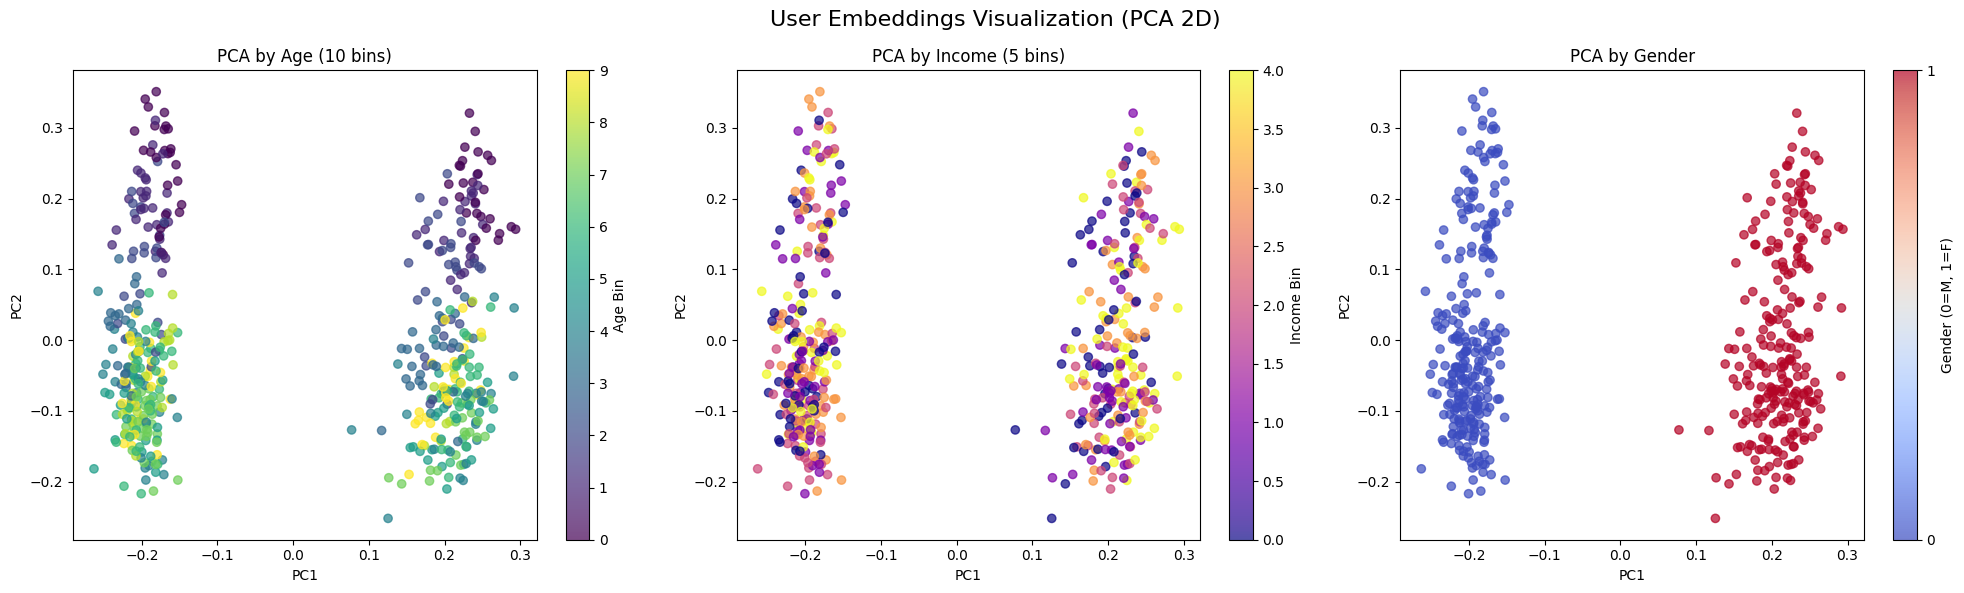

In [12]:
# 9. PCA 차원 축소 및 시각화 

import numpy as np
import ast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# DB에서 임베딩 + user_behavior 속성 불러오기
cur.execute("""
    SELECT ub.user_id, ub.age, ub.income, ub.gender, ue.embedding
    FROM user_behavior ub
    JOIN user_embeddings ue ON ub.user_id = ue.user_id;
""")
rows = cur.fetchall()

user_ids   = [r[0] for r in rows]
ages       = [r[1] for r in rows]
incomes    = [r[2] for r in rows]
genders    = [r[3] for r in rows]
embeddings = [ast.literal_eval(r[4]) if isinstance(r[4], str) else r[4] for r in rows]
embeddings = np.array(embeddings, dtype=float)

# PCA: 384차원 → 2차원
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 나이 구간 (10등분)
age_bins = pd.qcut(ages, 10, labels=False, duplicates="drop")

# 소득 구간 (5등분)
income_bins = pd.qcut(incomes, 5, labels=False, duplicates="drop")

# 성별 카테고리 (M/F → 0/1)
gender_map = {"M": 0, "F": 1}
gender_bins = [gender_map[g] for g in genders]

# 1행 3열 subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 나이 구간
sc1 = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=age_bins, cmap="viridis", alpha=0.7)
axes[0].set_title("PCA by Age (10 bins)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
fig.colorbar(sc1, ax=axes[0], label="Age Bin")

# 소득 구간
sc2 = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=income_bins, cmap="plasma", alpha=0.7)
axes[1].set_title("PCA by Income (5 bins)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
fig.colorbar(sc2, ax=axes[1], label="Income Bin")

# 성별
sc3 = axes[2].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=gender_bins, cmap="coolwarm", alpha=0.7)
axes[2].set_title("PCA by Gender")
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
fig.colorbar(sc3, ax=axes[2], ticks=[0,1], label="Gender (0=M, 1=F)")

plt.suptitle("User Embeddings Visualization (PCA 2D)", fontsize=16)
plt.tight_layout()
plt.show()

